# Bulk Walkthrough

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
from PAGEpy import plot_functions
from PAGEpy import pso as pso
from PAGEpy.dataset_class import GeneExpressionDataset
from PAGEpy.models import AdvancedNN, SimpleNN, TrainingConfig
import pickle
import pandas as pd
from PAGEpy import utils

2025-08-14 14:49:58.379149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755182998.393581    7326 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755182998.398002    7326 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# memory growth is enabled for for the gpu
gpu_available = utils.init_tensorflow()

14:50:18 [utils:21] GPU devices available: 1
14:50:18 [utils:26] Memory growth enabled for 1 GPU(s)
14:50:18 [utils:32] Mixed precision (float16) enabled


## Create Dataset

In [4]:
# TODO: instead of file patterns, use whole filenames
current_data = GeneExpressionDataset(
    data_dir="../../bulk_data/",
    counts_pattern="count_matrix.mtx",
    barcodes_pattern="sample_names.txt",
    # I think here it's possible to set already processed gene list:
    genes_pattern="gene_names.txt",
    metadata_pattern="response_labels.csv",
    gene_selection="Diff",
    pval_cutoff=0.00005,
    pval_correction="benjamini-hochberg",
    features_out_filename="bulk_feature_set.pkl",
    train_samples_out_filename="bulk_train_samples.txt",
    positive_label="yes"  # TODO: find out how Sean encoded it
)

/home/jovyan/.local/share/hatch/env/virtual/pagepy/RRSnIvUW/pagepy/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
14:50:21 [dataset_class:145] AnnData object constructed with 831 samples and 11528 features (genes).
14:50:21 [dataset_class:152] Counts normalized and log-transformed.
14:50:21 [dataset_class:204] Split data: 664 training samples, 167 test samples.
... storing 'Status' as categorical
... storing 'split' as categorical
/home/jovyan/.local/share/hatch/env/virtual/pagepy/RRSnIvUW/pagepy/lib/python3.12/site-packages/numba/cpython/old_hashing.py:477: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behav

In [5]:
# the selected genes can be loaded from the local directory, however, they are
# also an attribte of the GeneExpressionDataset object
genes_path = "bulk_feature_set.pkl"

with open(genes_path, "rb") as f:
    current_genes = pickle.load(f)
print(f"Loaded {len(current_genes)} genes as 'current_genes'")

Loaded 1757 genes as 'current_genes'


## Initialize and train NN Model

Set NN model parameters

In [6]:
# retrieved default params used in Sean's code
config = TrainingConfig(
    report_frequency=1,
    auc_threshold=1,
    learning_rate=0.001)

training_params = {
    # 'n_epochs': 50,
    'n_epochs': 500,
    'batch_size': 64,
    'seed': 42,
}

Train NN model before PSO

In [7]:
# Initialize NN model
initial_model = AdvancedNN(
    # initial_model = SimpleNN(
    n_input_features=len(current_genes),
    config=config,
)

# Train model
train_history = initial_model.train(
    x_train=current_data.x_train,
    y_train=current_data.y_train,
    x_test=current_data.x_test,
    y_test=current_data.y_test,
    **training_params,
)

/home/jovyan/.local/share/hatch/env/virtual/pagepy/RRSnIvUW/pagepy/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1755183033.376367    7326 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1755183033.377990    7326 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17716 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1755183034.444813    7530 service.cc:148] XLA service 0x7f4c2c00bc00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755183034.444833    7530 service.cc:156]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 3g.20gb, Compute Capability 8.0
I0000 00:00:1755183034.530009    7530 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:175518

14:51:36 [plot_functions:29] Max metrics
	Train Accuracy: 1.00 | Train AUC: 1.00 | Test Accuracy: 0.74 | Test AUC: 0.63


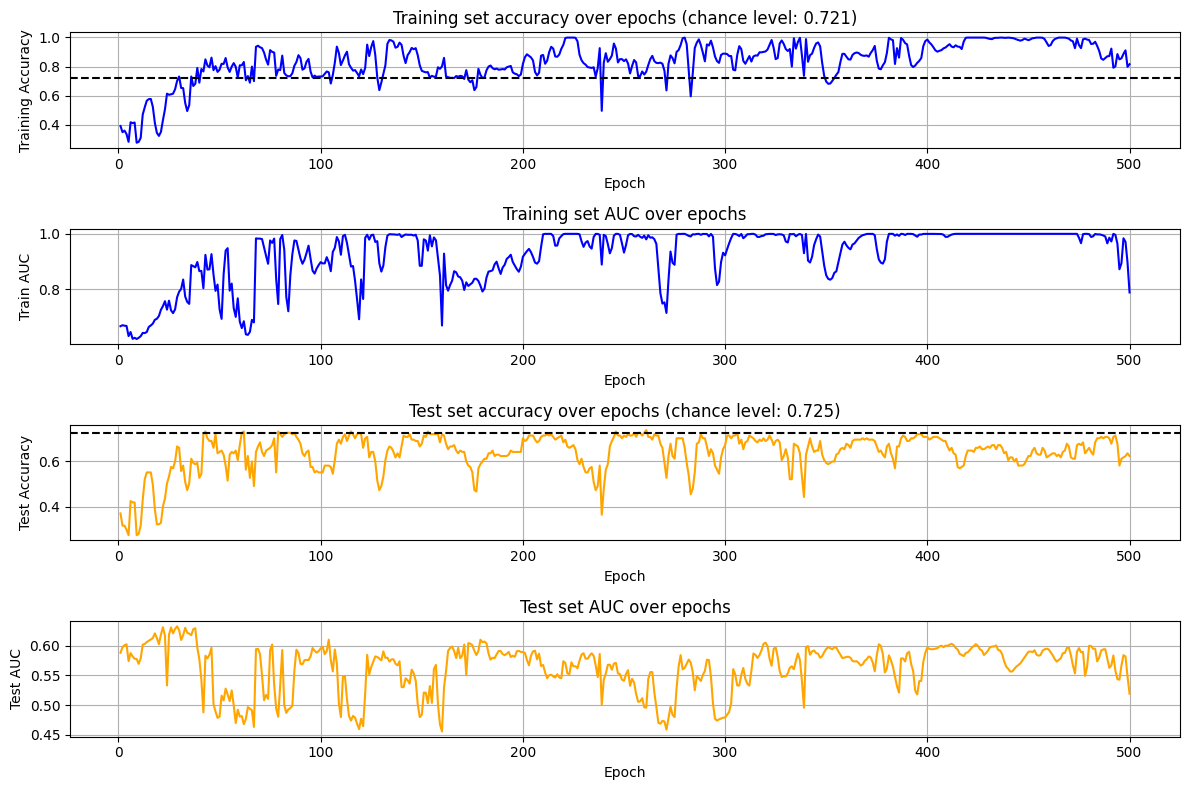

In [ ]:
plot_functions.plot_model_history(
    model_history=train_history,
    report_frequency=initial_model.config.report_frequency,
    y_train=current_data.y_train,
    y_test=current_data.y_test,
    save_path=None
)

## Run binary PSO

TO DO: is the algorithm leveraging the GPU??

In [ ]:
# the pso algorithm can be use to optimze the solution
best_solution, best_fitness = pso.run_binary_pso(
    input_data=current_data,
    feature_names=current_genes,
    pop_size=200,
    #pop_size=5,
    n_generations=15,
    #n_generations=2,
    w=1,
    c1=2,
    c2=1.5,
    # n_reps=4,
    n_reps=1,
    verbose=True,
    # verbose=False,
    adaptive_metrics=False,
    output_prefix="bulk_pso"
)

14:51:40 [pso:192] ============================================================
14:51:40 [pso:193] Generation 1 started
14:51:51 [fitness_functions:134] Particle 1: Genes=850 | Mean AUC=0.645 | Time=11.34s
14:52:03 [fitness_functions:134] Particle 2: Genes=852 | Mean AUC=0.649 | Time=11.22s
14:52:14 [fitness_functions:134] Particle 3: Genes=882 | Mean AUC=0.645 | Time=11.29s
14:52:25 [fitness_functions:134] Particle 4: Genes=870 | Mean AUC=0.639 | Time=11.25s
14:52:36 [fitness_functions:134] Particle 5: Genes=908 | Mean AUC=0.654 | Time=11.28s
14:52:48 [fitness_functions:134] Particle 6: Genes=859 | Mean AUC=0.642 | Time=11.33s
14:52:59 [fitness_functions:134] Particle 7: Genes=885 | Mean AUC=0.639 | Time=11.40s
14:53:10 [fitness_functions:134] Particle 8: Genes=914 | Mean AUC=0.655 | Time=11.30s
14:53:22 [fitness_functions:134] Particle 9: Genes=893 | Mean AUC=0.651 | Time=11.69s
14:53:34 [fitness_functions:134] Particle 10: Genes=905 | Mean AUC=0.635 | Time=11.52s
14:53:45 [fitness_f

In [ ]:
# the results of pso optimizatoin can be monitored
loaded_fitness_scores = pd.read_pickle("bulk_pso_fitness_scores.pkl")
loaded_particle_history = pd.read_pickle("bulk_pso_particle_history.pkl")

In [ ]:
plot_functions.plot_pso_fitness_evolution(loaded_fitness_scores)
plot_functions.plot_population_diversity(loaded_particle_history)
plot_functions.plot_feature_selection_frequency(
    loaded_particle_history)

## Initialize and train improved NN Model

In [ ]:
# the optimised solution is saved locally, however, the returned varible from
# the binary_pso function can also be passed to the model (see below)
# pso_genes = [item for item, m in zip(current_genes, best_solution) if m == 1]

# othervise just load the locally stored result file

# Load the saved genes list
with open("bulk_pso_selected_genes.pkl", "rb") as f:
    pso_genes = pickle.load(f)

In [ ]:
# now use this gene list to train a new model, which you can then evaluate
n_pso_input_features = len(pso_genes)

improved_model = AdvancedNN(
    # improved_model = SimpleNN(
    n_input_features=n_pso_input_features,
    config=config,
)

# select feature subset and scale data
x_train, x_test, y_train, y_test = current_data.get_scaled_feature_subset(
    feature_subset=pso_genes
)

# Train model
improved_train_history = improved_model.train(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    **training_params,
)

In [ ]:
plot_functions.plot_model_history(
    model_history=improved_train_history,
    report_frequency=improved_model.config.report_frequency,
    y_train=y_train,
    y_test=y_test,
    save_path=None
)